# Roadshow CreditCard Default Classifcation Demo

## CRISP-DM Data Science Process
<img src='CRISP-DM_Process_Diagram.png' width="600">

# CRISP-DM -- Business Understanding
See interactive discussion with Cyriel 😀

# CRISP-DM -- Data Understanding & Preparation

## Python Library Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import norm
from xgboost.sklearn import XGBClassifier
from sklearn.mixture import GaussianMixture, GMM
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.optimize import curve_fit
from sklearn.metrics import f1_score, roc_auc_score, recall_score

import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import neighbors
from IPython.display import display_html

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-ticks')

## Load CreditCard Default Data

In [6]:
cc_data = pd.read_csv('Default.csv', index_col=0, sep=';')

In [7]:
cc_data.shape

(10000, 4)

In [8]:
cc_data.head()

,default,student,balance,income
1,No,No,"729,5264952","44361,62507"
2,No,Yes,"817,1804066","12106,1347"
3,No,No,"1073,549164","31767,13895"
4,No,No,"529,2506047","35704,49394"
5,No,No,"785,6558829","38463,49588"


### Transform Data

In [9]:
cc_data.dtypes

default    object
student    object
balance    object
income     object
dtype: object

In [10]:
#Convert to correct types
cc_data['default'] = cc_data['default'].astype('category')
cc_data['student'] = cc_data['student'].astype('category')
cc_data['balance'] = cc_data['balance'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['income'] = cc_data['income'].apply(lambda str_flt : float(str_flt.replace(',','.'))).astype('float')
cc_data['default_encoded'] = cc_data.default.factorize()[0]
cc_data['student_encoded'] = cc_data.student.factorize()[0]

#Scaled variable for 
scaler = StandardScaler()
scaler.fit(cc_data[['balance']])
print(scaler.mean_)
cc_data['balance_scaled'] = scaler.transform(cc_data[['balance']])
scaler.fit(cc_data[['income']])
print(scaler.mean_)
cc_data['income_scaled'] = scaler.transform(cc_data[['income']])
cc_data = cc_data.sort_index(axis=1)

cc_data.dtypes

[835.37488561]
[33516.98187596]


balance             float64
balance_scaled      float64
default            category
default_encoded       int64
income              float64
income_scaled       float64
student            category
student_encoded       int64
dtype: object

In [11]:
cc_data.head()

,balance,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,-0.218835,No,0,44361.62507,0.813187,No,0
2,817.180407,-0.037616,No,0,12106.13470,-1.605496,Yes,1
3,1073.549164,0.492410,No,0,31767.13895,-0.131212,No,0
4,529.250605,-0.632893,No,0,35704.49394,0.164031,No,0
5,785.655883,-0.102791,No,0,38463.49588,0.370915,No,0


### Descriptive Statistics

In [12]:
cc_data.loc[:,['balance', 'balance_scaled', 'income', 'income_scaled']].describe()

,balance,balance_scaled,income,income_scaled
count,10000.000000,1.000000e+04,10000.000000,1.000000e+04
mean,835.374886,1.318279e-16,33516.981876,-5.646594e-17
std,483.714985,1.000050e+00,13336.639563,1.000050e+00
min,0.000000,-1.727085e+00,771.967729,-2.455390e+00
25%,481.731105,-7.311361e-01,21340.462905,-9.130582e-01
50%,823.636973,-2.426739e-02,34552.644800,7.765935e-02
75%,1166.308387,6.841840e-01,43807.729275,7.716533e-01
max,2654.322576,3.760559e+00,73554.233500,3.002200e+00


### Check Duplicates

In [13]:
dups = cc_data.duplicated(subset=['default','student','balance','income']).sum()
print('Aantal duplicaten: {}'.format(dups))

Aantal duplicaten: 0


### Check NaNs

In [14]:
cc_data.isnull().sum()

balance            0
balance_scaled     0
default            0
default_encoded    0
income             0
income_scaled      0
student            0
student_encoded    0
dtype: int64

## Explore CreditCard Default Data

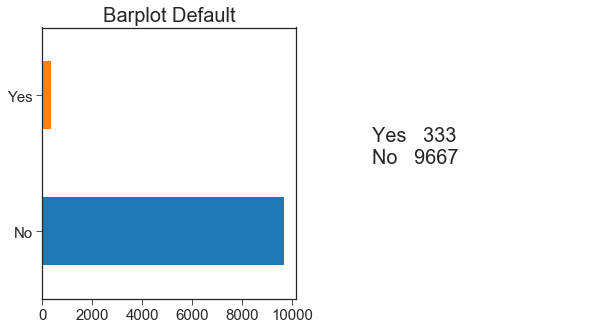

In [15]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
d_ax = cc_data.default.value_counts().plot.barh(fontsize=15, title='Barplot Default', ax=axes[0])
axes[0].title.set_size(20)

t_tbl = cc_data.default.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')

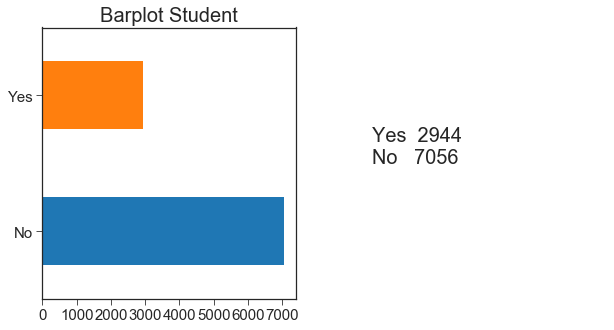

In [16]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
d_ax = cc_data.student.value_counts().plot.barh(fontsize=15, title='Barplot Student', ax=axes[0])
axes[0].title.set_size(20)

t_tbl = cc_data.student.value_counts().to_frame().sort_index(ascending=False)
t_ax = axes[1].text(0.1,0.5,t_tbl.to_string(header=False),size=20)
t_ax = axes[1].axis('off')

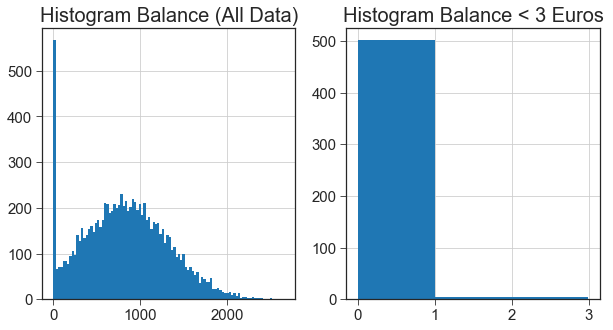

In [17]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
ax0 = cc_data.balance.hist(bins=100, ax=axes[0])
ax0.set_title('Histogram Balance (All Data)')
ax0.title.set_size(20)
ax0.tick_params(labelsize=15)
ax1 = cc_data.loc[cc_data.balance < 3, :].balance.hist(bins=3, ax=axes[1])
ax1.set_title('Histogram Balance < 3 Euros')
ax1.title.set_size(20)
ax1.tick_params(labelsize=15)

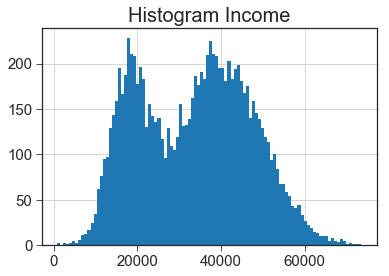

In [18]:
i_ax = cc_data.income.hist(bins=100)
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)

#### Explore Balance

In [19]:
print('\t Absolut Aantal Individuen < 1 euro op balance: {}\n'.format(cc_data.loc[cc_data.balance < 1, :].shape[0])
      ,'\t Percentage Aantal Individuen < 1 euro op balance: {}%'.format(cc_data.loc[cc_data.balance < 1, :].shape[0] / cc_data.shape[0] * 100))

	 Absolut Aantal Individuen < 1 euro op balance: 501
 	 Percentage Aantal Individuen < 1 euro op balance: 5.01%


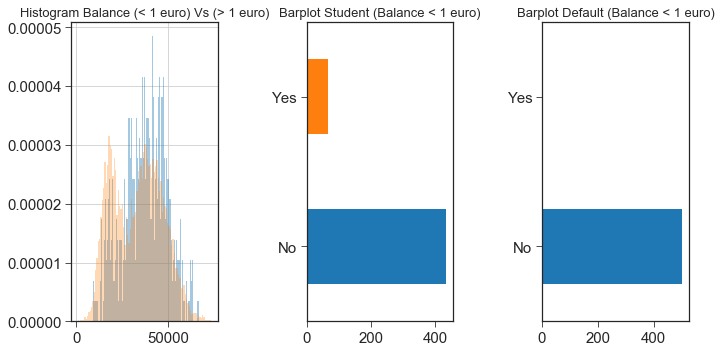

In [20]:
fig, axes = plt.subplots(1,3,figsize=(10,5))
cc_data.loc[cc_data.balance < 1, :].income.hist(bins=100, ax=axes[0], alpha=0.4, density=True)
cc_data.loc[cc_data.balance > 1, :].income.hist(bins=100, ax=axes[0], alpha=0.3, density=True)
axes[0].set_title('Histogram Balance (< 1 euro) Vs (> 1 euro)')
axes[0].title.set_size(13)
axes[0].tick_params(labelsize=15)
cc_data.loc[cc_data.balance < 1, :].student.value_counts().plot.barh(fontsize=15, title='Barplot Student (Balance < 1 euro)', ax=axes[1])
axes[1].title.set_size(13)
cc_data.loc[cc_data.balance < 1, :].default.value_counts().plot.barh(fontsize=15, title='Barplot Default (Balance < 1 euro)', ax=axes[2])
axes[2].title.set_size(13)
plt.tight_layout()

In [21]:
#Create variable less than 1 < euro (binary categorical)
cc_data['balance_lt_1_eur'] = np.NaN
cc_data.loc[cc_data.balance < 1,'balance_lt_1_eur'] = 1
cc_data.loc[cc_data.balance > 1,'balance_lt_1_eur'] = 0
cc_data['balance_lt_1_eur'] = cc_data['balance_lt_1_eur'].astype('int')
cc_data = cc_data.sort_index(axis=1)
cc_data.head()

,balance,balance_lt_1_eur,balance_scaled,default,default_encoded,income,income_scaled,student,student_encoded
1,729.526495,0,-0.218835,No,0,44361.62507,0.813187,No,0
2,817.180407,0,-0.037616,No,0,12106.13470,-1.605496,Yes,1
3,1073.549164,0,0.492410,No,0,31767.13895,-0.131212,No,0
4,529.250605,0,-0.632893,No,0,35704.49394,0.164031,No,0
5,785.655883,0,-0.102791,No,0,38463.49588,0.370915,No,0


### Explore Income

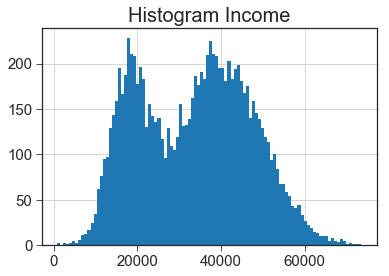

In [22]:
i_ax = cc_data.income.hist(bins=100)
i_ax.set_title('Histogram Income')
i_ax.title.set_size(20)
i_ax.tick_params(labelsize=15)

In [23]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

g1 = cc_data[cc_data.income < 26000].default.value_counts().rename('Income Group1').to_frame()
g1.index = g1.index.astype('object')
g1.at['Default %','Income Group1'] = 139/(3275+139) * 100
g1.at['No Default %','Income Group1'] = 3275/(3275+139) * 100
g2 = cc_data[cc_data.income >= 26000].default.value_counts().rename('Income Group2').to_frame()
g2.index = g2.index.astype('object')
g2.at['Default %','Income Group2'] = 194/(6392+194) * 100
g2.at['No Default %','Income Group2'] = 6392/(6392+194) * 100

display_side_by_side(g1, g2)

,Income Group1
No,3275.00000
Yes,139.00000
Default %,4.07147
No Default %,95.92853
,Income Group2
No,6392.000000
Yes,194.000000
Default %,2.945642
No Default %,97.054358


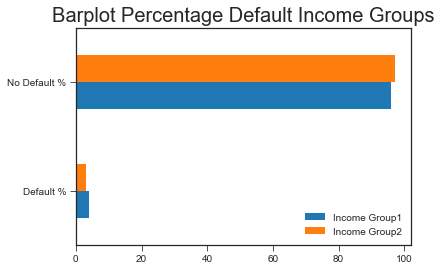

In [24]:
t = pd.concat([g1,g2] , axis=1).loc[['Default %','No Default %']].plot.barh()
tt = t.set_title('Barplot Percentage Default Income Groups')
t.title.set_size(20)

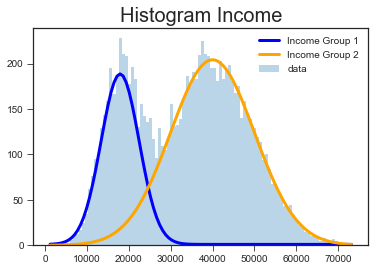

In [25]:
y,x,_= plt.hist(cc_data['income'],100,alpha=.3,label='data')

x=(x[1:]+ x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1) + gauss(x,mu2,sigma2,A2)

expected=(18000,1000,1,39000,5000,1)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(x,1+gauss(x,*params[3:]),color='blue',lw=3,label='Income Group 1')
plt.plot(x,gauss(x,*params[:3]),color='orange',lw=3,label='Income Group 2')
plt.title('Histogram Income').set_size(20)
t = plt.legend()

In [26]:
#TODO Create feature Income Group
cc_data['nv1'] = norm.pdf(cc_data['income'], loc=params[3], scale=params[4])
cc_data['nv2'] = norm.pdf(cc_data['income'], loc=params[0], scale=params[1])
cc_data['income_group'] = np.where(cc_data['nv1'] > cc_data['nv2'], 0, 1)
cc_data['income_group'] = cc_data['income_group'].astype('int')
cc_data = cc_data.drop(columns=['nv1','nv2'])
cc_data = cc_data.sort_index(axis=1)
cc_data.head()

,balance,balance_lt_1_eur,balance_scaled,default,default_encoded,income,income_group,income_scaled,student,student_encoded
1,729.526495,0,-0.218835,No,0,44361.62507,1,0.813187,No,0
2,817.180407,0,-0.037616,No,0,12106.13470,0,-1.605496,Yes,1
3,1073.549164,0,0.492410,No,0,31767.13895,1,-0.131212,No,0
4,529.250605,0,-0.632893,No,0,35704.49394,1,0.164031,No,0
5,785.655883,0,-0.102791,No,0,38463.49588,1,0.370915,No,0


In [27]:
cc_data.dtypes

balance              float64
balance_lt_1_eur       int64
balance_scaled       float64
default             category
default_encoded        int64
income               float64
income_group           int64
income_scaled        float64
student             category
student_encoded        int64
dtype: object

## Explore Predictive Value of Variables

In [28]:
#TODO Add Gini
def gini_score(y_true, y_score):
    return 2 * sklearn.metrics.roc_auc_score(y_true, y_score) - 1


def gini_plot(y_true, y_score, ax=None, title='', return_value='default'):
    if ax is None:
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
    ax.set_aspect('equal', 'box')
    fp_rate, tp_rate, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    ax.plot(fp_rate, tp_rate)
    ax.plot([0, 1], [0, 1])
    ax.set_title(title)
    ax.fill_between(fp_rate, tp_rate, fp_rate, alpha=.3)
    ax.set_xlabel('False positives')
    ax.set_ylabel('True positives')
    gini = gini_score(y_true, y_score)
    ax.text(0.5, 0.45, 'Gini: {:.3}'.format(gini), {'ha': 'center', 'va': 'center'}, rotation=45)
    if return_value == 'gini':
        return gini
    else:
        return fp_rate, tp_rate, thresholds

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

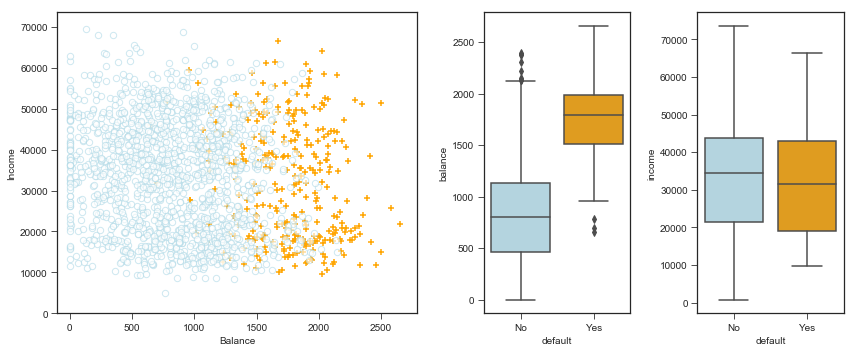

In [30]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = cc_data[cc_data.default_encoded == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = cc_data[cc_data.default_encoded == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=cc_data, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=cc_data, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

# CRISP-DM -- Modeling 
## Creating Classification Model

In [31]:
X = cc_data.loc[:,['student_encoded','balance_scaled','income_scaled','balance_lt_1_eur', 'income_group']]
y = cc_data.default_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

0    2906
1      94
Name: default_encoded, dtype: int64

In [32]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train)
y_lgr_pred = clf.predict(X_test)

In [33]:
xclas = XGBClassifier()  # and for classifier  
xclas.fit(X_train, y_train)  
y_xg_pred = xclas.predict(X_test)  

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Evaluate Technical Precision of Model

In [84]:
pd.DataFrame(y_test.value_counts())

,default_encoded
0,2906
1,94


In [ ]:
pproba_lgr = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
specificity = tn / (tn+fp)

/Users/Nx/anaconda/envs/py3env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


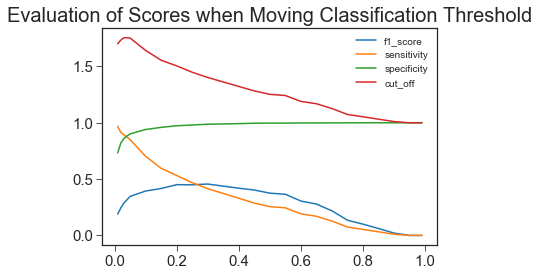

In [92]:
pproba_lgr = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [0.01, 0.02, 0.03, 0.04, 0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

y_lgr_scores = pd.DataFrame([], columns=['f1_score','sensitivity','specificity','cut_off'])
for i in threshold_list:
        y_lgr_pred_t = pproba_lgr.iloc[:,1].apply(lambda x: 1 if x>i else 0)
        y_lgr_scores.at[i,'f1_score'] = f1_score(y_test, y_lgr_pred_t)
        tn, fp, fn, tp = confusion_matrix(y_test, y_lgr_pred_t).ravel()
        y_lgr_scores.at[i,'sensitivity'] = recall_score(y_test, y_lgr_pred_t)
        y_lgr_scores.at[i,'specificity'] = specificity = tn / (tn+fp)
        y_lgr_scores.at[i,'cut_off'] = specificity + recall_score(y_test, y_lgr_pred_t)
        

t = y_lgr_scores.plot()
tt = t.set_title('Evaluation of Scores when Moving Classification Threshold').set_size(20)
t.tick_params(labelsize=15)

In [93]:
y_lgr_scores

,f1_score,sensitivity,specificity,cut_off
0.01,0.188993,0.968085,0.732278,1.70036
0.02,0.242595,0.914894,0.817963,1.73286
0.03,0.287179,0.893617,0.859945,1.75356
0.04,0.315992,0.87234,0.881968,1.75431
0.05,0.34632,0.851064,0.900895,1.75196
0.10,0.39403,0.702128,0.93978,1.64191
0.15,0.416357,0.595745,0.95905,1.55479
0.20,0.45045,0.531915,0.973159,1.50507
0.25,0.44898,0.468085,0.980041,1.44813
0.30,0.45614,0.414894,0.986924,1.40182


In [73]:
y_lgr_pred_t = pproba_lgr.iloc[:,1].apply(lambda x: 1 if x> 0.05 else 0)
roc_auc_score(y_test, y_lgr_pred_t)

0.875979265203321

In [44]:
roc_auc_score(y_test, y_xg_pred)

0.6463553030413963

In [94]:
y_lgr_pred_t = pproba_lgr.iloc[:,1].apply(lambda x: 1 if x> 0.04 else 0)
f1_score(y_test, y_lgr_pred_t)

0.3159922928709056

In [35]:
f1_score(y_test, y_xg_pred)

0.40875912408759124

In [96]:
y_lgr_pred_t = pproba_lgr.iloc[:,1].apply(lambda x: 1 if x> 0.04 else 0)
lgr_matrix = confusion_matrix(y_test, y_lgr_pred_t)
lgr_matrix

array([[2563,  343],
       [  12,   82]])

In [95]:
xg_matrix = confusion_matrix(y_test, y_xg_pred)
xg_matrix

array([[2891,   15],
       [  66,   28]])

Confusion matrix, without normalization
[[2563  343]
 [  12   82]]


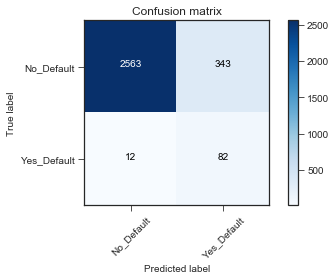

In [97]:
plot_confusion_matrix(lgr_matrix, classes=['No_Default','Yes_Default'],
                      title='Confusion matrix')

Confusion matrix, without normalization
[[2891   15]
 [  66   28]]


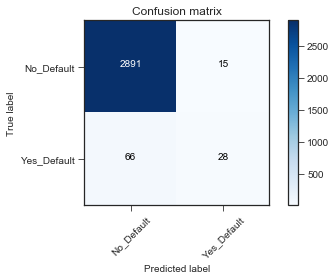

In [40]:
plot_confusion_matrix(xg_matrix, classes=['No_Default','Yes_Default'],
                      title='Confusion matrix')

# CRISP-DM Evaluation
## Evaluate Business Value

# CRISP-DM Deployment
Deploy model to production as web service or API for business users. Integrate this web service or API into business applications.